__Recommendation System - Movie Recommendation__
     

     
This task tests your ability to apply Recommendation Engine concepts and techniques to a real-world Movie Recommender System.


Task: Build a Movie Recommender system with the following methods:

Popularity
Content Filter
Collaborative Filter
Matrix Factorization


Also, try the following libraries on the dataset:

Turicreate
Surprise


Dataset: MovieLens 1M 

Hints:

1. Read Movies.csv, Ratings.csv and Tags.csv. No need for genome-scores.csv, genome-tags.csv

2. Create content filtering method on metadata obtained from merging movies and tags

3. Metadata should be formed from joining all tag field for each movie_title.

4. Build a Tfidf Vectorizer model and TruncatedSVD for Content filter - Latent matrix 1 on this data

5. Create a Collab filter on User Movie matrix (formed from pivot table on ratings data)

6. Create a Latent matrix 2 on this data

7. Code hybrid model


__Import Libraries__

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import wget
import turicreate as tc
import surprise as sp

__Download the data__

__Load & Read the dataset__

In [2]:
# Load the ratings data
ratings = pd.read_csv('ratings.dat', sep='::', header=None, engine='python',
                       names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin-1')

# Load the movies data
movies = pd.read_csv('movies.dat', sep='::', header=None, engine='python',
                     names=['movie_id', 'title', 'genres'], encoding='latin-1')

__Displaying the loaded data__

In [3]:
print("\nRatings Data :")
print("shape : ", ratings.shape)
print(ratings.head())


Ratings Data :
shape :  (1000209, 4)
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


In [4]:
print("\nmovies Data :")
print("shape : ", movies.shape)
print(movies.head())


movies Data :
shape :  (3883, 3)
   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [5]:
movies.columns

Index(['movie_id', 'title', 'genres'], dtype='object')

__1. Content Filtering__

Data Preparation for creating metadata to have a TF-IDF vectorizer for Content Filtering 

In [6]:
# Split the genres column on '|'
genres = movies['genres'].str.split('|', expand=True)

# Create binary columns for each genre
genre_dummies = pd.get_dummies(genres.stack()).groupby(level=0).sum()

# Concatenate the movie_id, title, and genre columns
tags = pd.concat([movies[['movie_id', 'title']], genre_dummies], axis=1)

In [7]:
# tags = tags[tags.movie_id.isin(ratings.movie_id)]
# tags.shape[0]

__Creating Metadata__

In [8]:
# Define a function to extract metadata for a specific genre
def metadata_genre(x, genre):
    if x == 1:
        return f" {genre} "
    else:
        return " "

# Define a list of genre names
genre_names = tags[['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]

# Loop over the genre names and apply the function to each genre column
for genre in genre_names:
    tags[f"metadata_{genre}"] = tags[genre].apply(lambda x: metadata_genre(x, genre))

In [9]:
tags['full_metadata'] = tags[['metadata_Action', 'metadata_Adventure',
'metadata_Animation', 'metadata_Children\'s', 'metadata_Comedy', 'metadata_Crime', 'metadata_Documentary', 'metadata_Drama', 'metadata_Fantasy',
'metadata_Film-Noir', 'metadata_Horror', 'metadata_Musical', 'metadata_Mystery', 'metadata_Romance', 'metadata_Sci-Fi', 'metadata_Thriller', 'metadata_War', 'metadata_Western']].apply(
                                          lambda x: ' '.join(x), axis = 1)

In [10]:
tags

,movie_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,metadata_Film-Noir,metadata_Horror,metadata_Musical,metadata_Mystery,metadata_Romance,metadata_Sci-Fi,metadata_Thriller,metadata_War,metadata_Western,full_metadata
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,,,,,,,,,,Animation Children's Comedy ...
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,,,,,,,,,,Adventure Children's Fantasy ...
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,,,,,Romance,,,,,Comedy Romance ...
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,,,,,,,,,,Comedy Drama
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,,,,,,,,,,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),0,0,0,0,1,0,0,0,...,,,,,,,,,,Comedy
3879,3949,Requiem for a Dream (2000),0,0,0,0,0,0,0,1,...,,,,,,,,,,Drama
3880,3950,Tigerland (2000),0,0,0,0,0,0,0,1,...,,,,,,,,,,Drama
3881,3951,Two Family House (2000),0,0,0,0,0,0,0,1,...,,,,,,,,,,Drama


__TF-IDF Vectorizer on Metadata__

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(tags['full_metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies.index.tolist())
tfidf_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.000000,0.728901,0.591714,0.344351,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.499814,0.000000,0.516339,0.000000,0.0,0.0,0.000000,0.6954,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.573172,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.819435,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.755606,0.0,0.0,0.655026,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3879,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3880,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3881,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


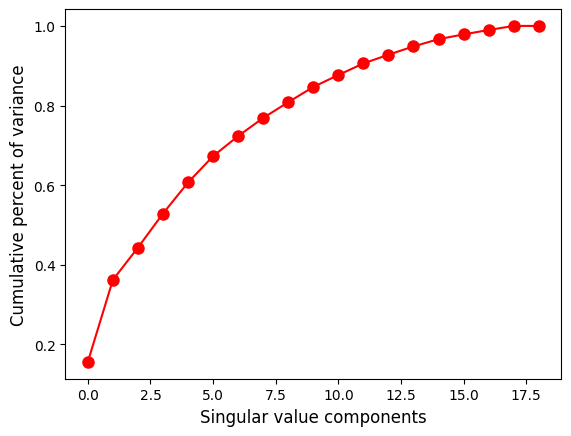

In [12]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=19)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [13]:
n = 20
latent_matrix_content_filtering = pd.DataFrame(latent_matrix[:,0:n], index=tags.title.tolist())

In [14]:
latent_matrix_content_filtering

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Toy Story (1995),0.115687,0.357232,0.002974,-0.063556,-0.050127,-0.107915,0.191194,0.610724,0.064025,0.002747,0.181453,-0.408850,-0.180056,-0.025713,-0.005629,0.420432,-0.038705,0.125267,1.733152e-18
Jumanji (1995),0.021029,0.037461,0.121268,0.006927,-0.092843,-0.260265,0.203342,0.658000,0.043430,-0.002113,-0.083026,0.209179,-0.112632,-0.021105,-0.015795,-0.386058,0.062183,0.462495,-2.144108e-19
Grumpier Old Men (1995),0.274386,0.642562,0.046693,0.694419,0.157187,0.017726,0.005593,-0.031968,0.004605,-0.000288,-0.019147,-0.012339,-0.023730,-0.013799,-0.004614,0.005260,0.000285,-0.003119,-2.088301e-17
Waiting to Exhale (1995),0.842228,0.499938,-0.106980,-0.160830,-0.026873,0.016574,0.003316,-0.033790,-0.022763,-0.005270,-0.021088,0.010166,0.001210,-0.003557,-0.007082,0.009146,0.000604,0.003392,3.293653e-18
Father of the Bride Part II (1995),0.298217,0.936961,-0.078427,-0.147266,-0.041892,0.030470,-0.006220,-0.041995,-0.015243,-0.004040,-0.009514,0.018802,0.000607,-0.001120,-0.006905,0.009570,-0.000116,0.003604,1.422114e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Meet the Parents (2000),0.298217,0.936961,-0.078427,-0.147266,-0.041892,0.030470,-0.006220,-0.041995,-0.015243,-0.004040,-0.009514,0.018802,0.000607,-0.001120,-0.006905,0.009570,-0.000116,0.003604,1.422114e-18
Requiem for a Dream (2000),0.941785,-0.317600,-0.072852,-0.075653,0.007299,-0.009845,0.012238,-0.003142,-0.017167,-0.003386,-0.021219,-0.006169,0.001148,-0.004138,-0.002847,0.002924,0.001057,0.001021,3.387795e-18
Tigerland (2000),0.941785,-0.317600,-0.072852,-0.075653,0.007299,-0.009845,0.012238,-0.003142,-0.017167,-0.003386,-0.021219,-0.006169,0.001148,-0.004138,-0.002847,0.002924,0.001057,0.001021,3.387795e-18
Two Family House (2000),0.941785,-0.317600,-0.072852,-0.075653,0.007299,-0.009845,0.012238,-0.003142,-0.017167,-0.003386,-0.021219,-0.006169,0.001148,-0.004138,-0.002847,0.002924,0.001057,0.001021,3.387795e-18


__2. Collaborative Filtering__

In [15]:
merged_data = pd.merge(tags,ratings,on='movie_id',how='outer')
merged_data

,movie_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,metadata_Mystery,metadata_Romance,metadata_Sci-Fi,metadata_Thriller,metadata_War,metadata_Western,full_metadata,user_id,rating,timestamp
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,,,,,,,Animation Children's Comedy ...,1.0,5.0,9.788243e+08
1,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,,,,,,,Animation Children's Comedy ...,6.0,4.0,9.782370e+08
2,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,,,,,,,Animation Children's Comedy ...,8.0,4.0,9.782335e+08
3,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,,,,,,,Animation Children's Comedy ...,9.0,5.0,9.782260e+08
4,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,,,,,,,Animation Children's Comedy ...,10.0,5.0,9.782265e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000381,3952,"Contender, The (2000)",0,0,0,0,0,0,0,1,...,,,,Thriller,,,Drama Thriller ...,5812.0,4.0,9.920721e+08
1000382,3952,"Contender, The (2000)",0,0,0,0,0,0,0,1,...,,,,Thriller,,,Drama Thriller ...,5831.0,3.0,9.862231e+08
1000383,3952,"Contender, The (2000)",0,0,0,0,0,0,0,1,...,,,,Thriller,,,Drama Thriller ...,5837.0,4.0,1.011903e+09
1000384,3952,"Contender, The (2000)",0,0,0,0,0,0,0,1,...,,,,Thriller,,,Drama Thriller ...,5927.0,1.0,9.798525e+08


In [16]:
user_movies_data= merged_data.pivot(index='movie_id',columns='user_id',values='rating').fillna(0)
user_movies_data

user_id,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,6031.0,6032.0,6033.0,6034.0,6035.0,6036.0,6037.0,6038.0,6039.0,6040.0
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=600)
latent_matrix_collaborative = svd.fit_transform(user_movies_data)
latent_matrix_collaborative_filtering = pd.DataFrame(latent_matrix_collaborative, index=movies.title.tolist())
latent_matrix_collaborative_filtering

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
Toy Story (1995),132.784373,-14.058038,-17.340275,2.518697,55.508155,7.595662,-0.035542,7.419392,-5.080137,-27.910449,...,-0.424323,-0.773526,-0.229560,-1.200890,-0.647111,0.186454,0.931496,-0.042832,-1.237984,1.372339
Jumanji (1995),44.573399,-20.000973,5.857215,-16.107409,4.262058,-2.169591,-13.422494,1.170187,4.537864,-8.881412,...,-1.184883,-1.430318,1.726088,-0.065465,-1.486114,1.282006,-1.758770,-2.410381,1.441803,2.215404
Grumpier Old Men (1995),26.061632,-11.214055,-7.227290,-14.062228,2.594795,2.326935,-2.418638,6.495406,-1.922111,0.955063,...,-1.369914,0.367904,-2.398920,1.787683,1.149965,0.601910,-1.109468,-0.057766,0.800192,1.531219
Waiting to Exhale (1995),10.078310,-1.989030,-7.102705,-7.808539,-1.168943,0.549981,-2.255726,-2.012779,1.381025,1.046471,...,-0.672548,-0.762787,-0.775896,2.152334,0.229159,-1.071078,-1.038174,0.129008,-0.312318,-0.149422
Father of the Bride Part II (1995),18.395406,-9.055474,-7.171111,-14.964850,1.917957,3.063567,-1.961754,4.847974,-1.605680,-0.106712,...,0.828912,0.017241,-0.535292,0.930034,-2.477515,-1.005113,-0.193344,0.195453,0.696882,-1.198133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Meet the Parents (2000),47.975035,-8.135795,-22.778547,8.547096,5.335573,-3.448148,-8.520964,10.735110,-3.917178,7.980567,...,2.012986,1.011433,0.452958,-0.550724,-1.960107,2.420797,0.331636,-1.622559,0.374763,-1.481768
Requiem for a Dream (2000),24.457903,3.746270,-12.838007,7.045934,-6.276300,-11.966488,-7.286283,-0.539987,2.006430,1.040301,...,0.534381,2.205617,0.480358,-0.088037,-3.053202,1.344239,-1.160822,-3.790899,-0.688242,-0.940629
Tigerland (2000),4.951244,1.258366,-1.025073,0.189323,-2.343650,-1.504852,-2.011101,0.402278,0.464818,0.813352,...,1.006570,0.317403,0.496371,-1.033685,0.684894,-0.150340,-0.236070,0.314880,0.079092,-0.254488
Two Family House (2000),2.208159,1.520669,-2.024009,0.574609,-0.385178,-1.108706,-2.178415,-0.500714,0.047734,1.301533,...,-0.697224,0.673975,-0.374103,-0.424815,0.491483,0.251197,-0.095182,0.756055,-1.228702,-0.477005


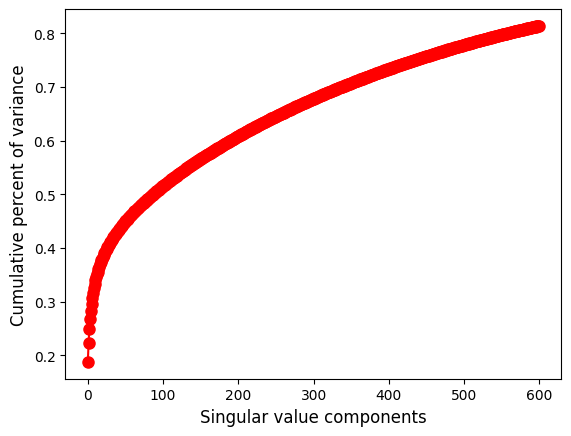

In [18]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)
plt.show()

__3. Hybrid__

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
def recommend_similar_movies(title):
    a_1 = np.array(latent_matrix_content_filtering.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_collaborative_filtering.loc[title]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_content_filtering, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_collaborative_filtering, a_2).reshape(-1)

    # an average measure of both content and collaborative 
    hybrid = ((score_1 + score_2)/2.0)

    # form a data frame of similar movies 
    dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_collaborative_filtering.index )

    #sort it on the basis of either: content, collaborative or hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    return (similar[1:].head(10))

In [21]:
recommend_similar_movies("Bambi (1942)")

,content,collaborative,hybrid
Pinocchio (1940),1.0,0.800809,0.900404
101 Dalmatians (1961),1.0,0.688451,0.844226
Charlotte's Web (1973),1.0,0.645319,0.822659
"Sword in the Stone, The (1963)",1.0,0.624290,0.812145
Robin Hood (1973),1.0,0.619321,0.809660
"Fox and the Hound, The (1981)",1.0,0.588537,0.794269
"Rescuers, The (1977)",1.0,0.587431,0.793715
"Aristocats, The (1970)",1.0,0.586389,0.793195
"Rescuers Down Under, The (1990)",1.0,0.556042,0.778021
Antz (1998),1.0,0.527340,0.763670


__4. Matrix Factorization Recommender__

- R – The user-movie rating matrix
- K – Number of latent features
- alpha – Learning rate for stochastic gradient descent
- beta – Regularization parameter for bias
- iterations – Number of iterations to perform stochastic gradient descent


In [22]:
class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [23]:
R= np.array(ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0))

In [24]:
R

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [25]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 20 ; error = 901.0833
Iteration: 40 ; error = 885.0825
Iteration: 60 ; error = 847.8815
Iteration: 80 ; error = 811.6353
Iteration: 100 ; error = 782.9660

P x Q:
[[4.44861031 3.40307096 3.47634893 ... 3.91099286 4.16546944 4.04021356]
 [4.15940764 3.20686369 3.27335562 ... 3.60179676 3.82990821 3.78606691]
 [3.83531886 3.366398   3.3346263  ... 3.76125177 4.13285154 3.96465013]
 ...
 [4.00643764 3.27369687 3.00618792 ... 3.54549653 3.93523473 3.78211411]
 [4.0863693  3.14424155 3.22885974 ... 3.60317342 3.96153872 3.88841605]
 [3.17722899 2.30454464 2.19380057 ... 3.21844593 3.62927473 3.37978846]]



In [26]:
def recommend_movies(user_id):
    # Get predicted ratings for the user using the trained model
    user_ratings = mf.full_matrix()[user_id - 1, :]

    # Get indices of the movies that the user has not watched yet
    unwatched_movies = np.where(R[user_id - 1, :] == 0)[0]

    # Sort predicted ratings in descending order and get the indices of the top-rated movies
    sorted_ratings = np.argsort(user_ratings[unwatched_movies])[::-1][:10]
    top_movies = unwatched_movies[sorted_ratings]

    # Get movie titles and ratings
    movie_titles = [movies.iloc[movie_id]['title'] for movie_id in top_movies]
    movie_ratings = [user_ratings[movie_id] for movie_id in top_movies]

    # Create dataframe with movie recommendations
    df = pd.DataFrame({'Movie Title': movie_titles, 'Predicted Rating': movie_ratings})

    # Add rank column
    df['Rank'] = df['Predicted Rating'].rank(method='first', ascending=False)

    # Reorder columns
    df = df[['Rank', 'Movie Title', 'Predicted Rating']]

    return df


In [27]:
recommend_movies(5)

,Rank,Movie Title,Predicted Rating
0,1.0,"Haunted World of Edward D. Wood Jr., The (1995)",4.603817
1,2.0,"Invitation, The (Zaproszenie) (1986)",4.558061
2,3.0,Hear My Song (1991),4.440488
3,4.0,"Candidate, The (1972)",4.423287
4,5.0,Aiqing wansui (1994),4.384018
5,6.0,Dumb & Dumber (1994),4.366806
6,7.0,Alien (1979),4.363796
7,8.0,Jennifer 8 (1992),4.358537
8,9.0,Resurrection Man (1998),4.352049
9,10.0,"Leopard Son, The (1996)",4.329050


__5. Popularity Recommender__

In [28]:
# Group ratings by movie title and calculate mean rating
movie_ratings = merged_data.groupby('title')['rating'].mean().reset_index()

# Merge the movie_ratings with tags to get movie_id for each movie title
movie_ratings = pd.merge(movie_ratings, tags, on='title')

# Sort movies by mean rating
popular_movies = movie_ratings.sort_values(by='rating', ascending=False).reset_index(drop=True)

# Assign ranks to the popular movies based on mean rating
popular_movies['rank'] = popular_movies.index + 1

# Recommend the top 10 popular movies with title, movie_id, rating, and rank
recommended_movies = popular_movies.head(10).reset_index(drop=True)
recommended_movies = recommended_movies[['movie_id', 'title', 'rating', 'rank']]
print(recommended_movies)


   movie_id                                      title  rating  rank
0      3172                    Ulysses (Ulisse) (1954)     5.0     1
1      3656                               Lured (1947)     5.0     2
2      1830                    Follow the Bitch (1998)     5.0     3
3      3881                   Bittersweet Motel (2000)     5.0     4
4      3382                     Song of Freedom (1936)     5.0     5
5      3607                   One Little Indian (1973)     5.0     6
6      3233                       Smashing Time (1967)     5.0     7
7       989  Schlafes Bruder (Brother of Sleep) (1995)     5.0     8
8       787         Gate of Heavenly Peace, The (1995)     5.0     9
9      3280                           Baby, The (1973)     5.0    10


__Turicreate__

In [29]:
import turicreate as tc

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
ratings_train, ratings_test = train_test_split(ratings, test_size=0.2, random_state=42)

In [32]:
train_data = tc.SFrame(ratings_train)
test_data = tc.SFrame(ratings_test)

Turicreate on Collaborative Filtering

In [33]:
item_sim_model = tc.item_similarity_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating', similarity_type='cosine')

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 800167 observations with 6040 users and 3683 items.

Data prepared in: 0.550142s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 4.598ms                        | 16.5       |

| 8.414ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 30.528ms                            | 0                | 3               |

| 947.756ms                           | 100              | 3683            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.99409s

In [34]:
item_sim_recomm = item_sim_model.recommend(users=[1,2,3,4,5],k=5)
item_sim_recomm.print_rows(num_rows=25)

+---------+----------+---------------------+------+
| user_id | movie_id |        score        | rank |
+---------+----------+---------------------+------+
|    1    |   1196   |  1.139431944707545  |  1   |
|    1    |   1198   |  1.0657942600366546 |  2   |
|    1    |   1265   |  0.9711356192100339 |  3   |
|    1    |   1210   |  0.9161372649960402 |  4   |
|    1    |   364    |  0.8428912453535127 |  5   |
|    2    |   377    |  0.7981424025439341 |  1   |
|    2    |   1196   |  0.7660750314730023 |  2   |
|    2    |   1580   |  0.7394978398576789 |  3   |
|    2    |   733    |  0.6590891223435008 |  4   |
|    2    |   608    |  0.6237045821793582 |  5   |
|    3    |   1196   |  1.2793952866298397 |  1   |
|    3    |   2000   |  1.0277204658926986 |  2   |
|    3    |   1270   |  1.0255494132274534 |  3   |
|    3    |   1036   |  0.9819175978986229 |  4   |
|    3    |   592    |  0.9691949777486848 |  5   |
|    4    |   1200   |  1.593503280689842  |  1   |
|    4    | 

* Matrix factorization recommenders using Turicreate

In [35]:
factor_model = tc.ranking_factorization_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating',  num_factors=600)

Preparing data set.

Data has 800167 observations with 6040 users and 3683 items.

Data prepared in: 0.710583s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 600      |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 100020 / 800167 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | Not Viable                               |

| 4       | 0.0651042         | No Decrease (2.61882 >= 2.44654)         |

| 5       | 0.016276          | 2.06341                                  |

| 6       | 0.00813802        | 1.95899                                  |

| 7       | 0.00406901        | 2.03621                                  |

| 8       | 0.00203451        | 2.24544                                  |

| 9       | 0.00101725        | 2.3401                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00813802        | 1.95899                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 235us        | 2.44384           | 1.11643               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 5.62s        | 2.12298           | 1.1423                | 0.00813802  |

| 2       | 11.04s       | 2.06731           | 1.10893               | 0.00813802  |

| 3       | 16.24s       | 1.91413           | 1.05511               | 0.00813802  |

| 4       | 21.47s       | 1.8804            | 1.04522               | 0.00813802  |

| 5       | 26.62s       | 1.85736           | 1.03874               | 0.00813802  |

| 7       | 37.49s       | 1.8374            | 1.03092               | 0.00813802  |

| 8       | 42.81s       | 1.83049           | 1.02859               | 0.00813802  |

| 9       | 48.35s       | 1.82318           | 1.02555               | 0.00813802  |

| 10      | 53.97s       | 1.81707           | 1.02349               | 0.00813802  |

| 11      | 59.74s       | 1.80799           | 1.0203                | 0.00813802  |

| 12      | 1m 4s        | 1.80041           | 1.01885               | 0.00813802  |

| 13      | 1m 10s       | 1.78944           | 1.01507               | 0.00813802  |

| 14      | 1m 15s       | 1.78128           | 1.01376               | 0.00813802  |

| 15      | 1m 21s       | 1.776             | 1.01271               | 0.00813802  |

| 16      | 1m 26s       | 1.76929           | 1.01046               | 0.00813802  |

| 17      | 1m 31s       | 1.76268           | 1.00926               | 0.00813802  |

| 18      | 1m 37s       | 1.75723           | 1.00768               | 0.00813802  |

| 19      | 1m 43s       | 1.75178           | 1.0065                | 0.00813802  |

| 20      | 1m 48s       | 1.74749           | 1.00554               | 0.00813802  |

| 21      | 1m 54s       | 1.74259           | 1.00429               | 0.00813802  |

| 22      | 1m 59s       | 1.73812           | 1.00317               | 0.00813802  |

| 23      | 2m 5s        | 1.73416           | 1.00236               | 0.00813802  |

| 24      | 2m 10s       | 1.72995           | 1.00132               | 0.00813802  |

| 25      | 2m 16s       | 1.72742           | 1.00025               | 0.00813802  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.74232

Final training RMSE: 0.99523

In [36]:
factor_recomm = factor_model.recommend(users=[1,2,3,4,5],k=5)
factor_recomm.print_rows(num_rows=25)

+---------+----------+--------------------+------+
| user_id | movie_id |       score        | rank |
+---------+----------+--------------------+------+
|    1    |   318    |  4.55587519977518  |  1   |
|    1    |   1198   | 4.533380302528819  |  2   |
|    1    |   1196   | 4.405710014442882  |  3   |
|    1    |   858    | 4.3938058492941465 |  4   |
|    1    |   593    | 4.379395137469253  |  5   |
|    2    |   260    | 4.658965787778577  |  1   |
|    2    |   2762   | 4.642326674352368  |  2   |
|    2    |   527    | 4.609892087916812  |  3   |
|    2    |   1196   | 4.511753349493226  |  4   |
|    2    |   1197   | 4.461283407102307  |  5   |
|    3    |   318    | 4.634170470687529  |  1   |
|    3    |   2762   | 4.615025697204253  |  2   |
|    3    |   1196   | 4.566330490562102  |  3   |
|    3    |   527    | 4.546876458379408  |  4   |
|    3    |   2571   | 4.5427723395852055 |  5   |
|    4    |   858    | 4.417547055448374  |  1   |
|    4    |    50    | 4.325340

* Popularity Recommender using Turicreate

In [37]:
popularity_model = tc.popularity_recommender.create(train_data, user_id='user_id', item_id='movie_id', target='rating')

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 800167 observations with 6040 users and 3683 items.

Data prepared in: 0.398931s

800167 observations to process; with 3683 unique items.

In [38]:
popularity_recomm = popularity_model.recommend(users=[10,20,30,40,50],k=5)
popularity_recomm.print_rows(num_rows=25)

+---------+----------+-------+------+
| user_id | movie_id | score | rank |
+---------+----------+-------+------+
|    10   |   3172   |  5.0  |  1   |
|    10   |   1830   |  5.0  |  2   |
|    10   |   3881   |  5.0  |  3   |
|    10   |   787    |  5.0  |  4   |
|    10   |   3245   |  5.0  |  5   |
|    20   |   3172   |  5.0  |  1   |
|    20   |   1830   |  5.0  |  2   |
|    20   |   3881   |  5.0  |  3   |
|    20   |   787    |  5.0  |  4   |
|    20   |   3245   |  5.0  |  5   |
|    30   |   3172   |  5.0  |  1   |
|    30   |   1830   |  5.0  |  2   |
|    30   |   3881   |  5.0  |  3   |
|    30   |   787    |  5.0  |  4   |
|    30   |   3245   |  5.0  |  5   |
|    40   |   3172   |  5.0  |  1   |
|    40   |   1830   |  5.0  |  2   |
|    40   |   3881   |  5.0  |  3   |
|    40   |   787    |  5.0  |  4   |
|    40   |   3245   |  5.0  |  5   |
|    50   |   3172   |  5.0  |  1   |
|    50   |   1830   |  5.0  |  2   |
|    50   |   3881   |  5.0  |  3   |
|    50   | 

__Surprise__

In [39]:
from surprise import KNNWithMeans


In [40]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

* Collaborative Filtering with Surprise

In [41]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movie_id.tolist()))

In [42]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id','movie_id','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.8785


0.8784970844530164

In [43]:
def pred_user_rating(ui):
    if ui in ratings.user_id.unique():
        ui_list = ratings[ratings.user_id == ui].movie_id.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [44]:
user_id = 1
pred_user_rating(user_id)

,ratings
movies,
Babe (1995),4.898530
Almost Famous (2000),4.849581
Being There (1979),4.842281
12 Angry Men (1957),4.833080
Mr. Smith Goes to Washington (1939),4.830734
Sanjuro (1962),4.792144
"Great Escape, The (1963)",4.764787
Harold and Maude (1971),4.759497
Arsenic and Old Lace (1944),4.757055


In [45]:
pred_user_rating(25)

,ratings
movies,
Pather Panchali (1955),4.985905
"General, The (1927)",4.853793
Sleepless in Seattle (1993),4.851234
Sanjuro (1962),4.839288
Contact (1997),4.811509
"Conformist, The (Il Conformista) (1970)",4.796012
Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954),4.781797
"Princess Bride, The (1987)",4.756128
"Man for All Seasons, A (1966)",4.752884
